In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import anndata as ad

import sys
sys.path.append("/code/")
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_erode as cerd
import thalamus_merfish_analysis.distance_metrics as dm

from colorcet import glasbey

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
# if you reload thalamus_merfish_analysis.ccf_plots after this celzl has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

# Figure 5 - Unsupervised clustering methods

In [4]:
# same set of CCF regions we'll use for both NSF & SpaGCN similarity heatmaps
regions_nsf_spagcn = [
    "AD", "AV", "AM", "IAD", "LD", "VPM", "VPL", "LGd",
    "LGv", # added in b/c it has a unique NSF pattern
    "MD", "CL", "CM", "IMD", "PO", "LP", "VAL", "VM", 
    "RE", "PF", "VPMpc", "PCN", "SPA", "PVT", "MH", "LH", 
    "RT", 
    "ZI"  # added in b/c it has unique NSF patterns
]

In [5]:
# generate ccf_images & boundaries for the left hemisphere only
ccf_images_left_hemi = abc.get_ccf_labels_image(resampled=True, realigned=False, subset_to_left_hemi=True)
ccf_boundaries_left_hemi = cimg.sectionwise_label_erosion(ccf_images_left_hemi, distance_px=1, fill_val=0, return_edges=True)

In [6]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

# level at which to compare labels
ccf_level = 'structure'

## Fig 5A,B - SpaGCN domains in 3 example sections

In [7]:
# load all cells in the brain
obs = abc.get_combined_metadata(realigned=False)

/code/thalamus_merfish_analysis/abc_load_base.py:336: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cells_df = cells_df.replace("ZI-unassigned", "ZI")


In [8]:
# load in SpaGCN domain results
# temporarily a static file in '../code/resources' until I get a reproducible run setup for the spagcn capsule
spagcn_domains_df = pd.read_parquet('/code/thalamus_merfish_analysis/resources/spagcn_predicated_domains.parquet')
# need to convert to categories since they're imported as int64
spagcn_domains_df = spagcn_domains_df.astype('category')

# merge in & subset to just cells with SpaGCN domain predictions
obs_spagcn = pd.merge(obs, spagcn_domains_df, on='cell_label', how='inner')

# filter by thalamus coords to tighten up the image
obs_spagcn = abc.filter_by_thalamus_coords(obs_spagcn)

# erode the CCF structures
obs_spagcn_erode, ccf_label = cerd.label_cells_by_eroded_ccf(obs_spagcn.copy(), ccf_images_left_hemi, ccf_level=ccf_level)

### Fig5A - SpaGCN domains in 3 example sections

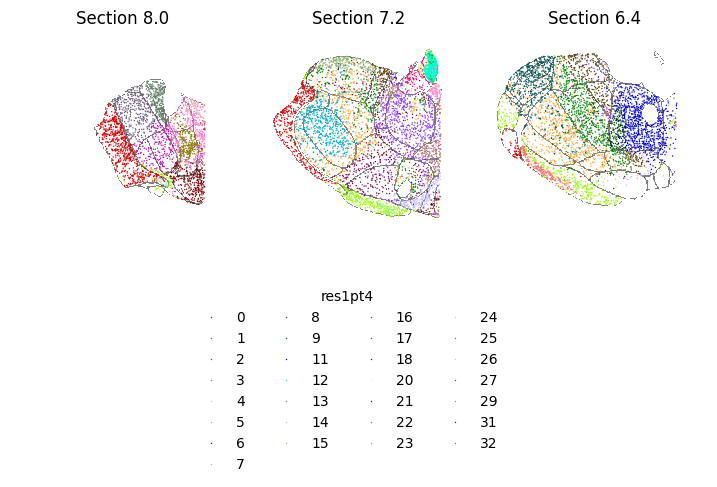

In [9]:
resolution = 1.4
res_str = str(resolution)
predicted_col = f'res{res_str[0]}pt{res_str[-1]}'

# make a color palette dict
color_palette = dict(zip(obs_spagcn_erode[predicted_col].cat.categories, glasbey))

# plot CCF overlaid on the SpaGCN domains
fig_spagcn_overlay = cplots.plot_ccf_overlay(
    obs_spagcn_erode,
    ccf_images_left_hemi,
    point_hue=predicted_col,
    point_palette=color_palette,
    min_group_count=0,
    sections=cplots.TH_EXAMPLE_Z_SECTIONS,
    separate_figs=False,
    figsize=(9,3),
    legend="cells",
    bg_cells=None,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    point_size=1,
    # edge_color="black",
    boundary_img=ccf_boundaries_left_hemi,
    custom_xy_lims=[2.5, 6, 7, 4],
)
fig_spagcn_overlay[0].savefig(f'../../results/spaGCN_domains_ccf_overlay_3sections_res{res_str}.pdf', 
            transparent=True, bbox_inches='tight')

### Fig5B - SpaGCN domains vs CCF regions - similarity heatmap

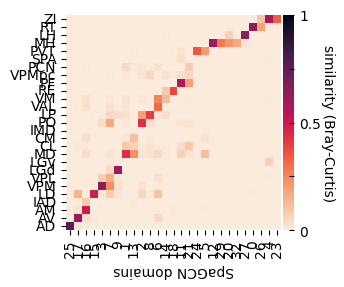

In [10]:
# ccf region order here is fairly arbitrary 
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn_erode, 
                            y_col=ccf_label, 
                            x_col=predicted_col, 
                            y_names=regions_nsf_spagcn, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()),
                            metric='braycurtis')

y_order, x_order = dm.order_distances_x_to_y(dist, 
                                             reorder_y=False,
                                             min_similarity_x=0.1)

fig_spagcn = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, 
                                         x_order=x_order, 
                                         y_names=y_names, 
                                         x_names=x_names)

fig_spagcn.set_size_inches(3.3,2.8)
fig_spagcn.gca().invert_yaxis()
plt.xlabel("SpaGCN domains", rotation=180)

fig_spagcn.savefig(f'../../results/spagcn_ccf_similarity_heatmap_fixed_order.pdf', 
                    transparent=True, bbox_inches='tight')

## Fig 5C,D - NSF patterns

In [11]:
# Load NSF anndata object
adata = ad.read_zarr("/root/capsule/data/nsf_2000_adata/nsf_2000_adata.zarr")
adata.X = adata.X.toarray()
adata.X = np.log2(1 + adata.X*1e6/np.sum(adata.X, axis=1, keepdims=True))

# filter by thalamus coords to tighten up the image
adata = abc.filter_by_thalamus_coords(adata)

In [12]:
# NSF patterns are stored in the obs
obs_nsf = adata.obs

# erode the CCF structures
obs_nsf_erode, ccf_label = cerd.label_cells_by_eroded_ccf(obs_nsf.copy(), ccf_images_left_hemi, ccf_level=ccf_level)

In [13]:
nsf_cols = [f"nsf{i}" for i in range(30)]
nsf_labels = range(30)

### Fig5C - NSF patterns in 3 example sections

In [14]:
# top patterns by # of cells
# across all 3 example sections
top_patterns_sections3 = obs_nsf.loc[obs_nsf[section_col].isin(cplots.TH_EXAMPLE_Z_SECTIONS), nsf_cols].max(axis=0).loc[lambda x: x>0.25].sort_values(ascending=False)

# per section (informational only; not used for plotting)
top_patterns_sec64 = obs_nsf.loc[obs_nsf[section_col]==cplots.TH_EXAMPLE_Z_SECTIONS[0], nsf_cols].max(axis=0).loc[lambda x: x>0.25].sort_values(ascending=False)
top_patterns_sec72 = obs_nsf.loc[obs_nsf[section_col]==cplots.TH_EXAMPLE_Z_SECTIONS[1], nsf_cols].max(axis=0).loc[lambda x: x>0.25].sort_values(ascending=False)
top_patterns_sec80 = obs_nsf.loc[obs_nsf[section_col]==cplots.TH_EXAMPLE_Z_SECTIONS[2], nsf_cols].max(axis=0).loc[lambda x: x>0.25].sort_values(ascending=False)

In [15]:
from thalamus_merfish_analysis import color_utils as cu
import seaborn as sns
def plot_patterns_ccf(
    obs,
    pattern_cols,
    section,
    # ccf shapes & props
    ccf_images=None,
    boundary_img=None,
    edge_color="grey",
    # column names
    section_col="brain_section_label",
    x_col="x_section",
    y_col="y_section",
    # point props
    pattern_palette=cu.glasbey,
    point_size=2,
    # formatting
    legend=True,
    figsize=(8, 4),
    **scatterplot_args):
    
    df = obs.loc[obs[section_col]==section]
    fig, ax = plt.subplots(figsize=figsize)
    for i, col in enumerate(pattern_cols):
        # allow palette to be either a dict or list
        if isinstance(pattern_palette, dict):
            color = pattern_palette[col]
        elif isinstance(pattern_palette, list):
            color = pattern_palette[i]
        
        # filter out cells where pattern=0 to minimize the number of points that
        # need to be plotted (each pattern is just layered on top of the previous ones)
        df_filtered = df.loc[df[col]>0].copy()

        # convert color to RGBA & scale Alpha by current pattern's value
        colors_rgba = (np.array(cu.to_rgba(color))[None,:] * 
                      (np.array([1,1,1,0]) + 
                       (np.array([0,0,0,1])*df_filtered[col].values[:,None])
                       )
                      )
        # add this pattern to the scatterplot 
        sns.scatterplot(df, 
                        c=colors_rgba, 
                        linewidth=0,
                        ax=ax, 
                        x=x_col,
                        y=y_col,
                        s=point_size, 
                        legend=False, **scatterplot_args)
        # plot empty scatter plot to create legend
        ax.scatter([], [], c=color, label=pattern_cols[i])
    
    # generate global legend for all patterns
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    cplots.plot_ccf_section(ccf_images, section, 
                    face_palette=None,
                    boundary_img=boundary_img, 
                    legend=False, ax=ax)
    return fig

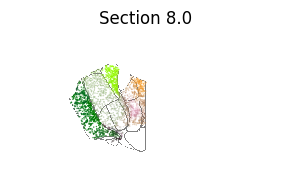

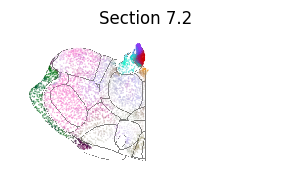

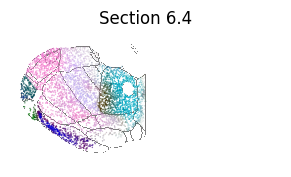

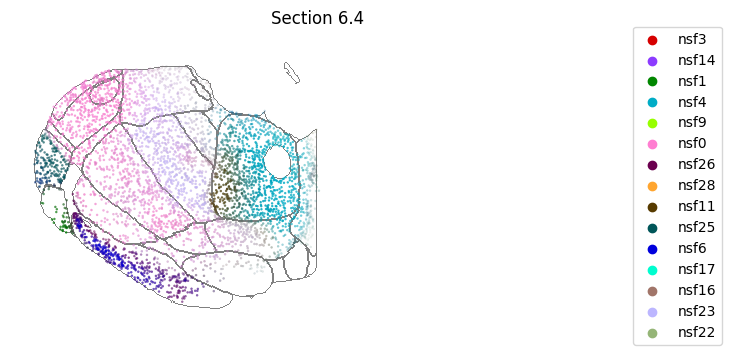

In [16]:
# reset to only plot thalamus structures
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

# save as pngs to save space
for sec in cplots.TH_EXAMPLE_Z_SECTIONS:
    fig = plot_patterns_ccf(
                                obs_nsf,
                                top_patterns_sections3.index[:15],
                                sec,
                                ccf_images=ccf_images_left_hemi,
                                boundary_img=ccf_boundaries_left_hemi,
                                section_col=section_col,
                                x_col=x_col,   
                                y_col=y_col,
                                point_size=1,
                                legend=False,
                                figsize=(3.5,3),
                                )
    fig.savefig(f"/results/nsf_top15_patterns_overlay_sec{int(sec*10)}.png", 
                transparent=True, bbox_inches='tight', dpi=1200)
    
# make one pdf figure to have a vector graphic of the legend
fig_pdf = plot_patterns_ccf(
                                obs_nsf,
                                top_patterns_sections3.index[:15],
                                sec,
                                ccf_images=ccf_images_left_hemi,
                                boundary_img=ccf_boundaries_left_hemi,
                                section_col=section_col,
                                x_col=x_col,   
                                y_col=y_col,
                                point_size=3,
                                legend=True,
                                # figsize=(3.5,3),
                                )
fig_pdf.savefig(f"/results/nsf_top15_patterns_overlay_sec{int(sec*10)}.pdf", 
                    transparent=True, bbox_inches='tight')

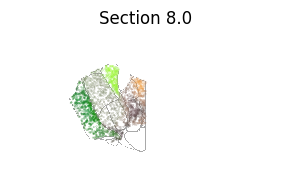

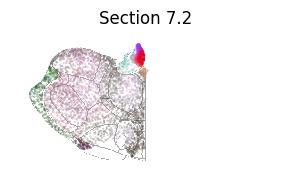

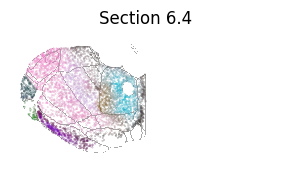

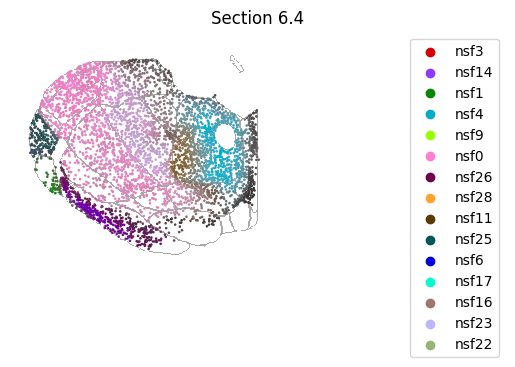

In [17]:
# reset to only plot thalamus structures
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

# patterns to plot
patterns = top_patterns_sections3.index[:15] #.sort_values()

kwargs = dict(
            ccf_images=ccf_images_left_hemi,
            boundary_img=ccf_boundaries_left_hemi,
            section_col=section_col,
            x_col=x_col,   
            y_col=y_col,
            normalize_by="all",
            dark_background=False,
)

# save as pngs to save space
for sec in cplots.TH_EXAMPLE_Z_SECTIONS:
    fig = cplots.plot_multichannel_overlay(
                    obs_nsf,
                    patterns,
                    sec,
                    colors=glasbey,
                    point_size=0.1,
                    legend=False,
                    figsize=(3.5,3),
                    **kwargs,
                    )
    fig.savefig(f"/results/nsf_top15_patterns_overlay_sec{int(sec*10)}.png", 
                transparent=True, bbox_inches='tight', dpi=1200)
    
# make one pdf figure to have a vector graphic of the legend
fig = cplots.plot_multichannel_overlay(
                    obs_nsf,
                    patterns,
                    sec,
                    colors=glasbey,
                    point_size=3,
                    legend=True,
                    # figsize=(3.5,3),
                    **kwargs,
                    )
fig_pdf.savefig(f"/results/nsf_top15_patterns_overlay_sec{int(sec*10)}.pdf", 
                    transparent=True, bbox_inches='tight')

### Fig5D - NSF patterns vs gene expression

In [18]:
kwargs = dict(
    section_col=section_col,
    x_col = x_col,
    y_col = y_col,
    custom_xy_lims=[2.6, 5.8, 7, 4],
    point_size=1,
    boundary_img=ccf_boundaries_left_hemi,
)

# reset to only plot thalamus structures
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

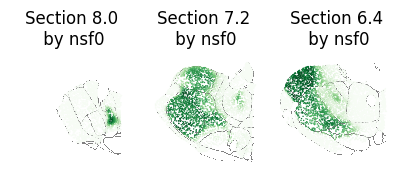

In [19]:
n = 0

fig_nsf0 = cplots.plot_ccf_overlay(
        obs_nsf, 
        ccf_images_left_hemi, 
        categorical=False,
        point_hue=f'nsf{n}', 
        sections=cplots.TH_EXAMPLE_Z_SECTIONS,
        point_palette='Greens', 
        legend=None,
        separate_figs=False,
        figsize=(5,2),
        **kwargs)
fig_nsf0[0].savefig(f'/results/nsf_n{n}_ccf_overlay_3sections.png',
                transparent=True, bbox_inches='tight', dpi=1200)

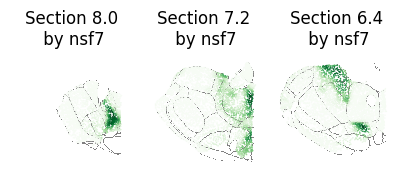

In [20]:
n = 7

fig_nsf0 = cplots.plot_ccf_overlay(
        obs_nsf, 
        ccf_images_left_hemi, 
        categorical=False,
        point_hue=f'nsf{n}', 
        sections=cplots.TH_EXAMPLE_Z_SECTIONS,
        point_palette='Greens', 
        legend=None,
        separate_figs=False,
        figsize=(5,2),
        **kwargs)
fig_nsf0[0].savefig(f'/results/nsf_n{n}_ccf_overlay_3sections.png',
                transparent=True, bbox_inches='tight', dpi=1200)

### Fig5E - NSF patterns vs CCF regions - similarity heatmap

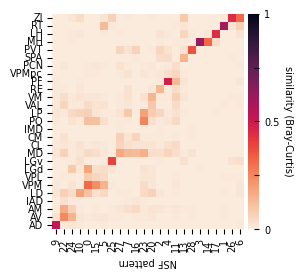

In [21]:
# order here is following thalamoseq fig 1
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_nsf_erode, 
                            y_col=ccf_label, 
                            x_col=nsf_cols, 
                            y_names=regions_nsf_spagcn, 
                            x_names=nsf_labels,
                            metric='braycurtis'
                            )

y_order, x_order = dm.order_distances_x_to_y(dist, 
                                          reorder_y=False, 
                                          min_similarity_x=0.1)

# plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 7})
fig_nsf_sim = dm.plot_ordered_similarity_heatmap(
    dist, 
    label="similarity (Bray-Curtis)",
    y_order=y_order, 
    x_order=x_order, 
    y_names=y_names, 
    x_names=x_names,
)
fig_nsf_sim.set_size_inches(3.0,2.8)
fig_nsf_sim.gca().invert_yaxis()
plt.xlabel("NSF pattern", rotation=180)
plt.savefig("/results/nsf_ccf_similarity_heatmap_ccf_order.pdf", transparent=True)